In [1]:
import anndata as ad
import crested
import numpy as np

2025-07-28 14:15:13.128830: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 14:15:13.142216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753737313.157049 1721312 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753737313.161523 1721312 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-28 14:15:13.177232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import matplotlib
import matplotlib.pyplot as plt

# Set the font type to ensure text is saved as whole words
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed

In [3]:
bigwigs_folder = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/results/"
regions_file = "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/results/astro_3subGroup_merged_peaks.bed"

By loading our genome in the {class}`crested.Genome` class and setting it with {func}`~crested.register_genome`, the genome is automatically used in all functions throughout CREsted. If you don't provide the chromomsome sizes, they will be automatically calculated from the fasta.
```{note}
Any function or class that expects a genome object can still accept a genome object as explicit input even if one was already registered. In that case, the input will be used instead of the registered genome. 
```

In [7]:
import os

genome_fasta  = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa"

# if you ever need a .chrom.sizes (for change_regions_width etc)
chr_sizes     = os.path.abspath(
    os.path.join(os.path.dirname(genome_fasta), "../star/chrNameLength.txt")
)

genome = crested.Genome(
   genome_fasta, chr_sizes)

crested.register_genome(
    genome
)  # Register the genome so that it can be used by the package

print(genome.fetch("chr1", 10000, 10010))

2025-07-28T14:19:16.435554-0700 INFO Genome genome registered.
TAACCCTAAC


We can use the {func}`~crested.import_bigwigs` function to import bigwigs per cell type and a consensus regions BED file into an {class}`anndata.AnnData` object,
with the imported cell types as the `AnnData.obs` and the consensus peak regions as the `AnnData.var`.  

In [53]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000,
    target="count",
)
adata

2025-07-16T16:56:22.423238-0700 INFO Extracting values from 3 bigWig files...


AnnData object with n_obs × n_vars = 3 × 348543
    obs: 'file_path'
    var: 'chr', 'start', 'end'

In [54]:
adata.X = np.nan_to_num(adata.X, nan=0.0)

In [55]:
adata.var

,chr,start,end
region,,,
GL000009.2:114171-114672,GL000009.2,114171,114672
GL000194.1:21903-22404,GL000194.1,21903,22404
GL000194.1:21158-21659,GL000194.1,21158,21659
GL000194.1:24959-25460,GL000194.1,24959,25460
GL000194.1:24273-24774,GL000194.1,24273,24774
...,...,...,...
chrY:56871936-56872437,chrY,56871936,56872437
chrY:56872718-56873219,chrY,56872718,56873219
chrY:56873502-56874003,chrY,56873502,56874003


To train a model, we always need to add a *split* column to our dataset, which we can do using {func}`crested.pp.train_val_test_split`.  
This will add a column to the `AnnData.var` with the split type for each region (train, val, or test).

In [56]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata, strategy="chr", val_chroms=["chr10"], test_chroms=["chr18"]
)

print(adata.var["split"].value_counts())
adata.var.head(3)

split
train    321537
val       18515
test       8491
Name: count, dtype: int64


,chr,start,end,split
region,,,,
GL000009.2:114171-114672,GL000009.2,114171,114672,train
GL000194.1:21903-22404,GL000194.1,21903,22404,train
GL000194.1:21158-21659,GL000194.1,21158,21659,train


## Preprocessing

### Region Width

For this example we're interested in training on wider regions than our consensus regions file (500bp) to also include some sequence information from the tails of our peaks.  

We change it to 2114 bp regions since that is what the Chrombpnet architecture was originally trained on and that's what we'll be using. This is not fixed and can be adapted to what you prefer, as long as it is compatible with the model architecture. 

Wider regions will mean that you don't only include sequence information from the center of the peaks and could effectively increase your dataset size if the tails of the peak include meaningful information, but could also introduce noise if the tails are not informative.  
Wider regions will also increase the computational cost of training the model. 

In [57]:
crested.pp.change_regions_width(
    adata,
    2114,
)  # change the adata width of the regions to 2114bp

2025-07-16T16:56:41.883138-0700 WARNING Region GL000194.1:189771-191885 with coordinates GL000194.1:189771-191885 is out of bounds for chromosome GL000194.1. Removing region.
2025-07-16T16:56:41.886183-0700 WARNING Region GL000205.2:-619-1494 with coordinates GL000205.2:-619-1494 is out of bounds for chromosome GL000205.2. Removing region.
2025-07-16T16:56:41.892422-0700 WARNING Region GL000219.1:177700-179814 with coordinates GL000219.1:177700-179814 is out of bounds for chromosome GL000219.1. Removing region.


### Peak Normalization

Additionally, we can normalize our peak values based on the variability of the top peak heights per cell type using the {func}`crested.pp.normalize_peaks` function.  


This function applies a normalization scalar to each cell type, obtained by comparing per cell type the distribution of peak heights for the maximally accessible regions which are not specific to any cell type.

In [58]:
adata_tmp=adata.copy()

In [59]:
crested.pp.normalize_peaks(
    adata, top_k_percent=0.03
)  # The top_k_percent parameters can be tuned based on potential bias towards cell types. If some weights are overcompensating too much, consider increasing the top_k_percent. Default is 0.01

2025-07-16T16:57:04.376256-0700 INFO Filtering on top k Gini scores...
2025-07-16T16:57:05.023156-0700 INFO Added normalization weights to adata.obsm['weights']...


,chr,start,end,split
region,,,,
chr20:56391291-56393405,chr20,56391291,56393405,train
chr5:115625076-115627190,chr5,115625076,115627190,train
chr5:115840828-115842942,chr5,115840828,115842942,train
chr14:66506982-66509096,chr14,66506982,66509096,train
chr7:31051239-31053353,chr7,31051239,31053353,train
...,...,...,...,...
chr11:121655102-121657216,chr11,121655102,121657216,train
chr11:121654592-121656706,chr11,121654592,121656706,train
chr3:160754469-160756583,chr3,160754469,160756583,train


We can visualize the normalization factor for each cell type using the {func}`crested.pl.bar.normalization_weights` function to inspect which cell type peaks were up/down weighted.

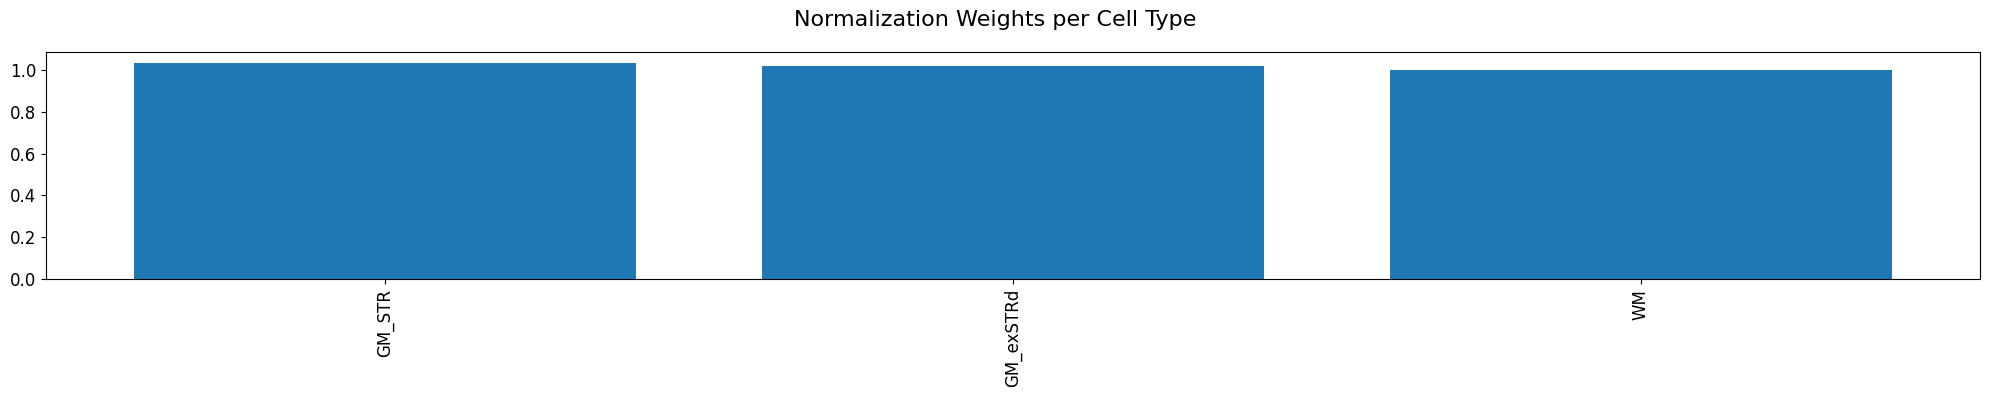

In [60]:
%matplotlib inline
crested.pl.bar.normalization_weights(
    adata, title="Normalization Weights per Cell Type", x_label_rotation=90, height=4
)

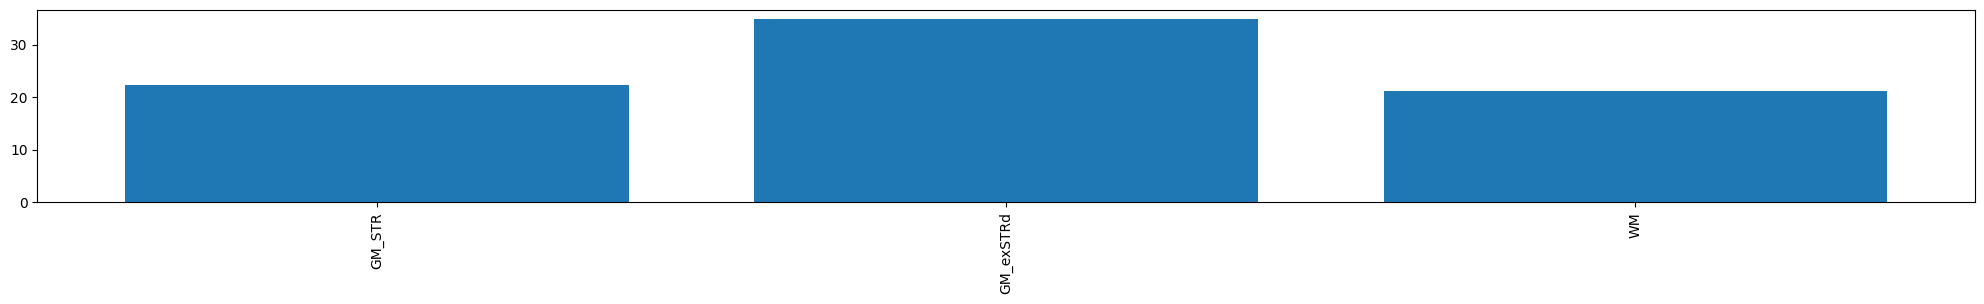

In [61]:
# Sanity checks
reg="chrY:56871129-56873243"	
idx = np.argwhere(adata.var.index==reg)[0,0]
plt.figure(figsize=(25,2.5))
plt.bar(adata.obs_names, adata.X.T[idx])
plt.xticks(rotation=90)
plt.show()

In [62]:
adata.var

,chr,start,end,split
region,,,,
GL000009.2:113364-115478,GL000009.2,113364,115478,train
GL000194.1:21096-23210,GL000194.1,21096,23210,train
GL000194.1:20351-22465,GL000194.1,20351,22465,train
GL000194.1:24152-26266,GL000194.1,24152,26266,train
GL000194.1:23466-25580,GL000194.1,23466,25580,train
...,...,...,...,...
chrY:56871129-56873243,chrY,56871129,56873243,train
chrY:56871911-56874025,chrY,56871911,56874025,train
chrY:56872695-56874809,chrY,56872695,56874809,train


In [63]:
adata.obs_names

Index(['GM_STR', 'GM_exSTRd', 'WM'], dtype='object')

There is no single best way to preprocess your data, so we recommend experimenting with different preprocessing steps to see what works best for your data.  
Likewise there is no single best training approach, so we recommend experimenting with different training strategies.

In [45]:
# Save the final preprocessing results
adata.write_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_subset_universe.h5ad")

### Subsetting to DARs

In [31]:
adata = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_subset_universe.h5ad")
adata_norm = adata.obsm['weights']

In [34]:
adata_dars = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file="/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/results/unique_DAR_peaks_humanAstro.bed",
    target_region_width=1000,
    target="count",
)
adata_dars

2025-07-16T16:45:29.777773-0700 INFO Extracting values from 3 bigWig files...


AnnData object with n_obs × n_vars = 3 × 11998
    obs: 'file_path'
    var: 'chr', 'start', 'end'

In [35]:
adata_dars.X = np.nan_to_num(adata_dars.X, nan=0.0)

In [36]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata_dars, strategy="chr", val_chroms=["chr10"], test_chroms=["chr18"]
)

print(adata_dars.var["split"].value_counts())
adata_dars.var.head(3)

split
train    11073
val        722
test       203
Name: count, dtype: int64


,chr,start,end,split
region,,,,
chr1:925420-925921,chr1,925420,925921,train
chr1:924775-925276,chr1,924775,925276,train
chr1:999900-1000401,chr1,999900,1000401,train


In [37]:
crested.pp.change_regions_width(
    adata_dars,
    2114,
)  # change the adata width of the regions to 2114bp

In [49]:
adata_dars.X[0] = adata_dars.X[0] * adata_norm[0]
adata_dars.X[1] = adata_dars.X[1] * adata_norm[1]
adata_dars.X[2] = adata_dars.X[2] * adata_norm[2]

In [50]:
adata_dars.write_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_dars.h5ad")

### Finetuning on cell type-specific regions

#### Subsetting the consensuspeak set

For peak regression models, we recommend to continue training the model trained on all consensuspeaks on a subset of cell type-specific regions.
Since we are interested in understanding the enhancer code uniquely identifying the cell types in the dataset, finetuning on specific regions will allow us to approach that.
We define specific regions as regions with a high Gini index, indicating that their peak distribution over all cell types will be skewed and specific for one or more cell types.

Read the documentation of the {func}`crested.pp.filter_regions_on_specificity` function for more information on how the filtering is done.  

In [4]:
adata = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_subset_universe.h5ad")

crested.pp.filter_regions_on_specificity(
    adata, gini_std_threshold=1
)  # All regions with a Gini index 1 std above the mean across all regions will be kept
adata

2025-07-16T16:05:50.110618-0700 INFO After specificity filtering, kept 46722 out of 348540 regions.


AnnData object with n_obs × n_vars = 3 × 46722
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split'
    obsm: 'weights'

In [5]:
adata.X.T[0]

array([185.99265, 121.83143,  88.64006], dtype=float32)

In [6]:
import pandas as pd
X = adata.X

# Transpose to (cell types, peaks)
X_T = X.T  # shape = (n_celltypes, n_regions)
cell_types = list(adata.var_names)  # 1 label per column

# Convert to long-form DataFrame
df = pd.DataFrame(X_T, index=cell_types)

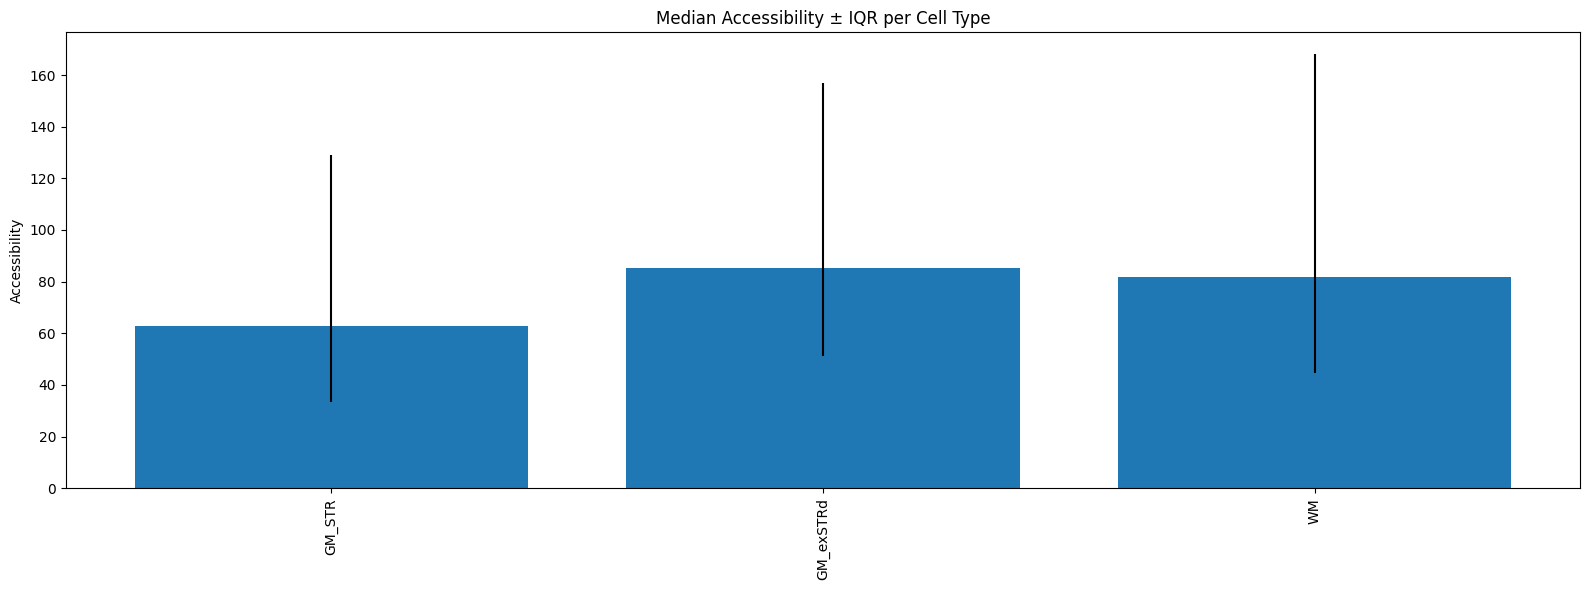

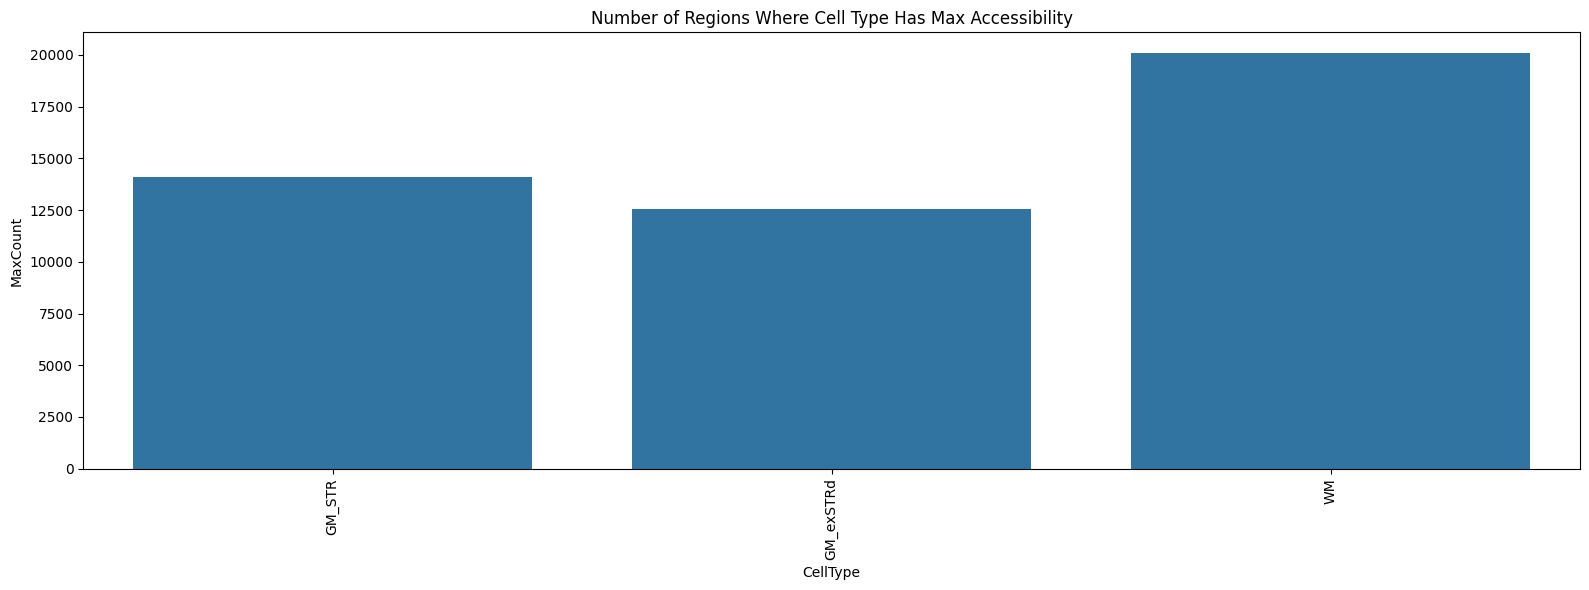

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
%matplotlib inline

# Get the matrix and ensure it's dense
X = adata.X
if sparse.issparse(X):
    X = X.toarray()

# Transpose to (cell types, peaks)
X_T = X.T  # shape = (n_celltypes, n_regions)
cell_types = list(adata.obs_names)  # 1 label per column

# Convert to long-form DataFrame
df = pd.DataFrame(X_T, columns=cell_types)

medians = df.median()
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)

plt.figure(figsize=(16, 6))
plt.bar(cell_types, medians, yerr=[medians - q1, q3 - medians])
plt.xticks(rotation=90)
plt.ylabel("Accessibility")
plt.title("Median Accessibility ± IQR per Cell Type")
plt.tight_layout()
plt.show()

# --- Bar plot: how often each cell type is the most accessible per region ---
max_indices = X.T.argmax(axis=1)  # index of max cell type per region
max_counts = np.bincount(max_indices, minlength=len(cell_types))

bar_df = pd.DataFrame({
    'CellType': cell_types,
    'MaxCount': max_counts
})

plt.figure(figsize=(16, 6))
sns.barplot(data=bar_df, x='CellType', y='MaxCount')
plt.xticks(rotation=90)
plt.title("Number of Regions Where Cell Type Has Max Accessibility")
plt.tight_layout()
plt.show()

In [8]:
adata.write_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_subset_universe_ft.h5ad")

## Evaluate the model

After training, we can evaluate the model on the test set using the {meth}`~crested.tl.Crested.test` method.  
If we're still in the same session, we can simply continue using the same object.  
If not, we can load the model from disk using the{func}`~crested.tl.Crested.load_model` method.
This means that we have to create a new {class}`~crested.tl.Crested` object first.  
However, this time, since the taskconfig and architecture are saved in the .keras file, we only have to provide our datamodule.

In [8]:
#adata = ad.read_h5ad("data/mouse_cortex_filtered.h5ad")
import crested
import anndata as ad
adata= ad.read_h5ad("//allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_dars.h5ad")

datamodule = crested.tl.data.AnnDataModule(
    adata,
    batch_size=64,  # lower this if you encounter OOM errors
)

In [9]:
adata.shape

(3, 11998)

In [11]:
# load an existing model
evaluator = crested.tl.Crested(data=datamodule)
#model_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_human/full_universe_base/checkpoints/10.keras"
#model_path_2 = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_human/maxweight1_full_universe_base/checkpoints/17.keras"
#model_path_ft = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_human/subset_universe_base_subset_ft//checkpoints/01.keras"
#model_path_ft_2 = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_human/full_universe_base_subset_filtered_ft_2/checkpoints/07.keras"
#model_path_dar= "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_human/subset_universe_base_subset_ft_dars_ft///checkpoints/13.keras"
model_path_dar_2= "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/astro_human/full_universe_base_subset_filtered_ft_2_dars_ft///checkpoints/05.keras"
#model_path_dar_3= "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_human/full_universe_base_subset_filtered_ft_2_dars_ft///checkpoints/26.keras"

### Predict

Now we have a trained model, we can use the ```crested.tl``` toolkit to run inference and explain our results. All the functionality shown below only expects a trained .keras model, meaning that you can use these functions with any model trained outside of the crested framework too.

```{warning}
An older version of crested used to handle all this functionality inside the {class}`~crested.tl.Crested` class. For ease of use, we refactored these methods to a functional form as shown below. You can still use them in its old object-method manner, but they are considered deprecated and will only be updated in its functional form.
```

The core function that you will be using is the {meth}`~crested.tl.predict` function. This expects as input something you want to predict over as well as trained model. You can even provide a list of models, as long as they expect the same input and output shapes. In that case the predictions will be averaged, which can be useful to make your predictions more robust. 

Since crested is build around making predictions over genomic sequences, this can accept as input:
- (lists of) sequence(s)
- (lists of) genomic region name(s)
- one hot encoded sequences of shape (N, L, 4)
- anndata objects with regions as its .var index

Crested will convert these inputs to its required format for the model.  
If your input is a region name or anndata, you should provide a genome as well if you did not register one.

First, we need to load a model. If you followed the tutorial you can load that one. 
If not, crested has a 'model repository' with commonly used models which you can download with 
{meth}`~crested.get_model`. You can find all example models [here](https://crested.readthedocs.io/en/latest/models/index.html).

In [12]:
# load a trained model
import keras

#model = keras.models.load_model(model_path, compile=False) 
#model_2 = keras.models.load_model(model_path_2, compile=False) 
#model_ft = keras.models.load_model(model_path_ft, compile=False) 
#model_ft_2 = keras.models.load_model(model_path_ft_2, compile=False) 
#model_dar = keras.models.load_model(model_path_dar, compile=False) 
model = keras.models.load_model(model_path_dar_2, compile=False)
#model_dar_3 = keras.models.load_model(model_path_dar_3, compile=False) 

In [13]:
import tensorflow as tf

print("[INFO] Available physical devices:")
print(tf.config.list_physical_devices())
print("[INFO] Is GPU available?", tf.config.list_physical_devices("GPU"))

[INFO] Available physical devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[INFO] Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
import importlib
import crested  # first import
importlib.reload(crested)  # reimport after editing

<module 'crested' from '/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/crested/__init__.py'>

In [15]:
import pysam
from tqdm import tqdm
fasta = pysam.FastaFile(genome_fasta)

seqs = [
    fasta.fetch(chrom, start, end)
    for chrom, start, end in tqdm(zip(adata.var['chr'], adata.var['start'], adata.var['end']))
]

11998it [01:03, 187.79it/s]


In [17]:
# store predictions for all our regions in the anndata object for later inspection.
names = ['Base', 'Base_2', 'Subset', 'Subset_2', 'Dar', 'Dar_2', 'Dar_3']
names = ['AstroModel']
#for m, n in zip([model, model_2, model_ft, model_ft_2, model_dar, model_dar_2, model_dar_3], names):
for m, n in zip([model], names):
    predictions = crested.tl.predict(seqs, m, verbose=2)
    adata.layers[n] =predictions.T  # adata expects (C, N) instead of (N, C)

I0000 00:00:1753737689.130004 1721455 service.cc:148] XLA service 0x7fb8600043c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753737689.130811 1721455 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-07-28 14:21:29.175294: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753737689.269215 1721455 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-07-28 14:21:32.715745: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,512,1,1055]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,512,1,1057]{3,2,1,0}, f32[512,512,1,3]{3,2,1,0}), window={size=1x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,

94/94 - 42s - 446ms/step


Many of the plotting functions in the `crested.pl` module can be used to visualize these model predictions.  

#### Example predictions on test set regions

It is always interesting to see how the model performs on unseen test set regions. It is recommended to always look at a few examples to spot potential biases, or trends that you do not expect.

In [18]:
# Define a dataframe with test set regions
test_df = adata.var[adata.var["split"] == "test"]
test_df

,chr,start,end,split
region,,,,
chr18:394157-396271,chr18,394157,396271,test
chr18:432472-434586,chr18,432472,434586,test
chr18:4454303-4456417,chr18,4454303,4456417,test
chr18:5894417-5896531,chr18,5894417,5896531,test
chr18:5895067-5897181,chr18,5895067,5897181,test
...,...,...,...,...
chr18:49975926-49978040,chr18,49975926,49978040,test
chr18:77168009-77170123,chr18,77168009,77170123,test
chr18:44819060-44821174,chr18,44819060,44821174,test


In [19]:
np.argmax(adata.X.T, axis=0)

array([11346, 11346, 11346])

chr1:20223676-20225790
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2025-07-28T14:22:24.973067-0700 INFO Plotting bar plots for region: chr1:20223676-20225790, models: ['AstroModel']


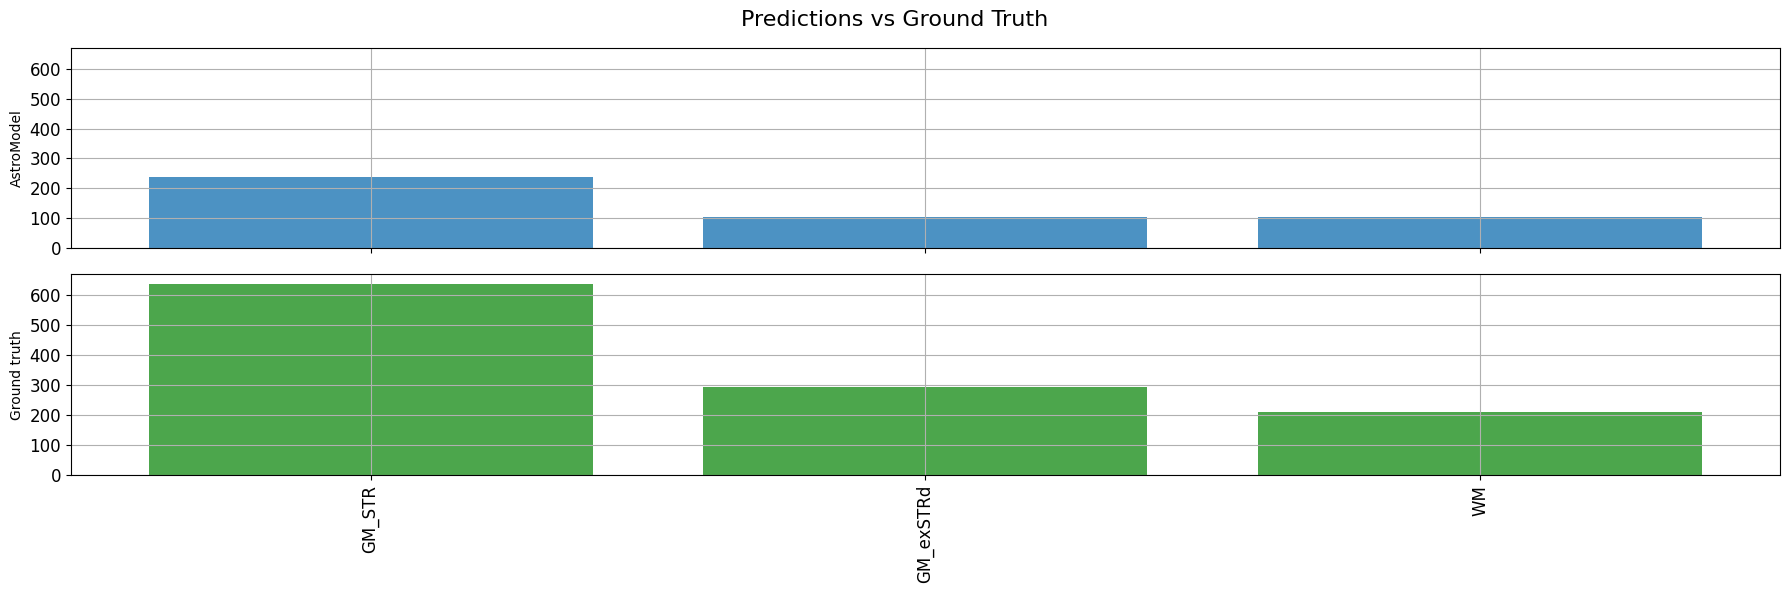

In [21]:
%matplotlib inline
# plot predictions vs ground truth for a random region in the test set defined by index
idx = 43
region = adata.var.index[idx]#test_df.index[idx]
print(region)
chrom = region.split(':')[0]
start = int(region.split(':')[1].split('-')[0])
end=start+2114
sequence = genome.fetch(chrom, start, end)
prediction = crested.tl.predict(sequence, model)
#prediction_ft = crested.tl.predict(sequence, model_ft)


#crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))
#crested.pl.bar.prediction(prediction_ft, classes=list(adata.obs_names))

crested.pl.bar.region_predictions(adata, region, title="Predictions vs Ground Truth", x_label_rotation=90)

#### Model performance on the entire test set

After looking at specific instances, now we can look at the model performance on a larger scale.

First, we can check per cell type/class the correlation of predictions and peak heights over the peaks in the test set.  

These plotting that show predictions over your entire dataset expect them to be saved in your `anndata.layer` object. 

2025-07-28T14:43:28.073178-0700 INFO Plotting density scatter for all targets and predictions, models: ['AstroModel'], split: test


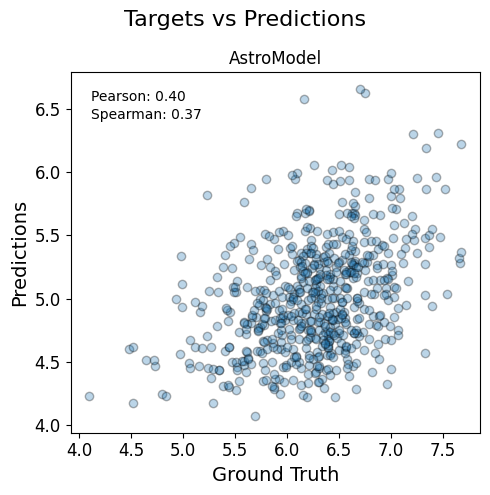

In [37]:
classn = None#"Ependymal"
crested.pl.scatter.class_density(
    adata,
    class_name=classn,
    model_names=['AstroModel'],
    split="test",
    log_transform=True,
    width=5,
    height=5,
    alpha=0.3,
    save_path='scatter.pdf',
)

To now check the correlations between all classes, we can plot a heatmap to assess the model performance.

2025-07-28T14:32:37.182263-0700 INFO Plotting heatmap correlations for split: test, models: ['AstroModel']


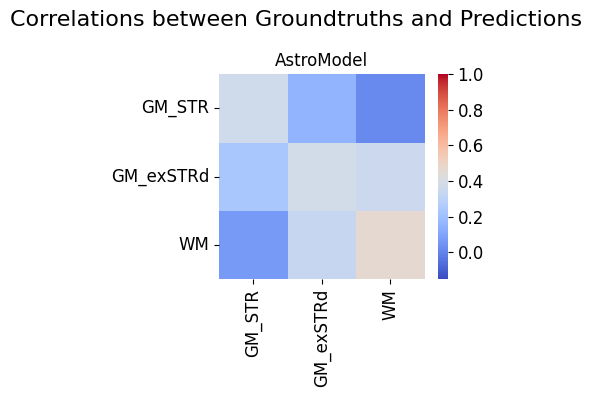

In [34]:
crested.pl.heatmap.correlations_predictions(
    adata,
    split="test",
    title="Correlations between Groundtruths and Predictions",
    x_label_rotation=90,
    width=4*len(names),
    height=4,
    log_transform=True,
    vmax=1,
    vmin=-0.15,
    save_path='heatmap.pdf'
)

It is also recommended to compare this heatmap to the self correlation plot of the peaks themselves. If peaks between cell types are correlated, then it is expected that predictions from non-matching classes for correlationg cell types will also be high.

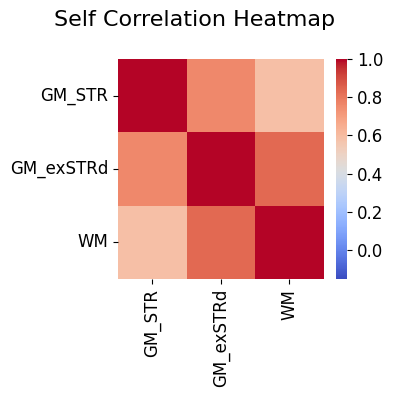

In [35]:
crested.pl.heatmap.correlations_self(
    adata,
    title="Self Correlation Heatmap",
    x_label_rotation=90,
    width=4,
    height=4,
    vmax=1,
    vmin=-0.15,
    save_path='self_corr.pdf'
)

In [26]:
spec= crested.pp._utils._calc_proportion(adata.X.T)
np.argmax(spec, axis=0)


array([ 948, 9876, 2178])

#### Contribution scores on random test set regions

In [29]:
# plot predictions vs ground truth for a random region in the test set defined by index
idx = 545
region = adata.var.index[idx]#test_df.index[idx]
classes_of_interest = ['GM_STR', 'GM_exSTRd', 'WM']
class_idx = list(adata.obs_names.get_indexer(classes_of_interest))
#scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
##    region,
##    target_idx=class_idx,
##    model=model_dar,
##    method='integrated_grad'
#)
scores_2, one_hot_encoded_sequences = crested.tl.contribution_scores(
    region,
    target_idx=class_idx,
    model=model,
    method='integrated_grad'
)
#scores_3, one_hot_encoded_sequences = crested.tl.contribution_scores(
#    region,
#    target_idx=class_idx,
#    model=model_dar_3,
#    method='integrated_grad'
#)

2025-07-28T14:26:05.073601-0700 INFO Calculating contribution scores for 3 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


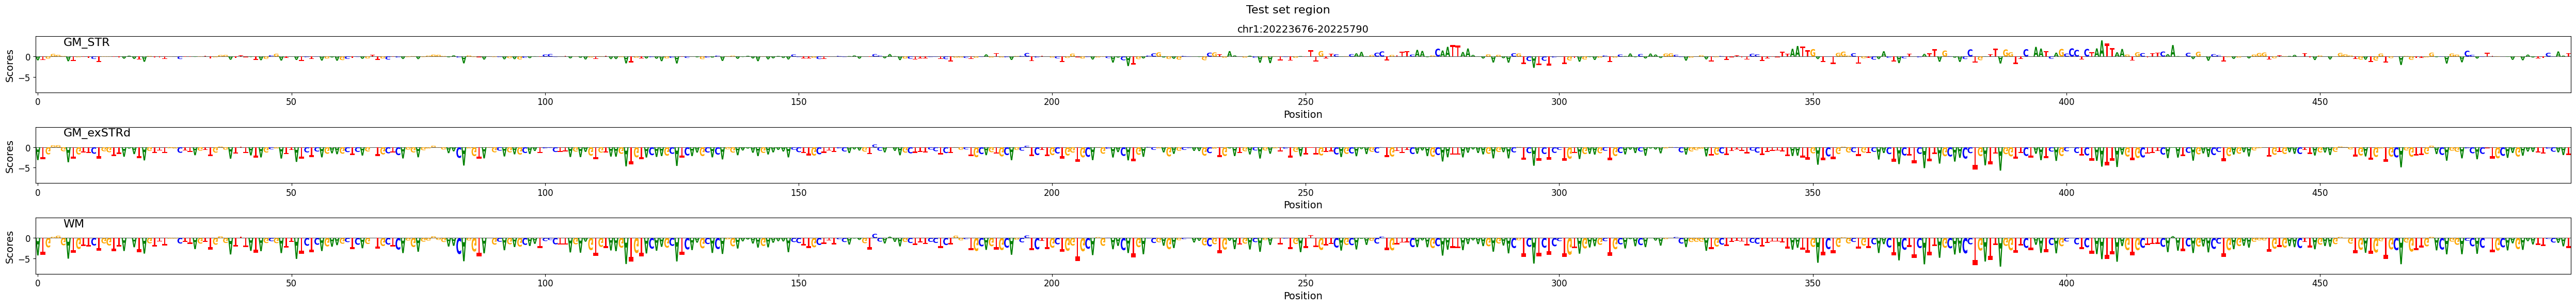

In [69]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[region],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
)  # zoom in on the center 500bp

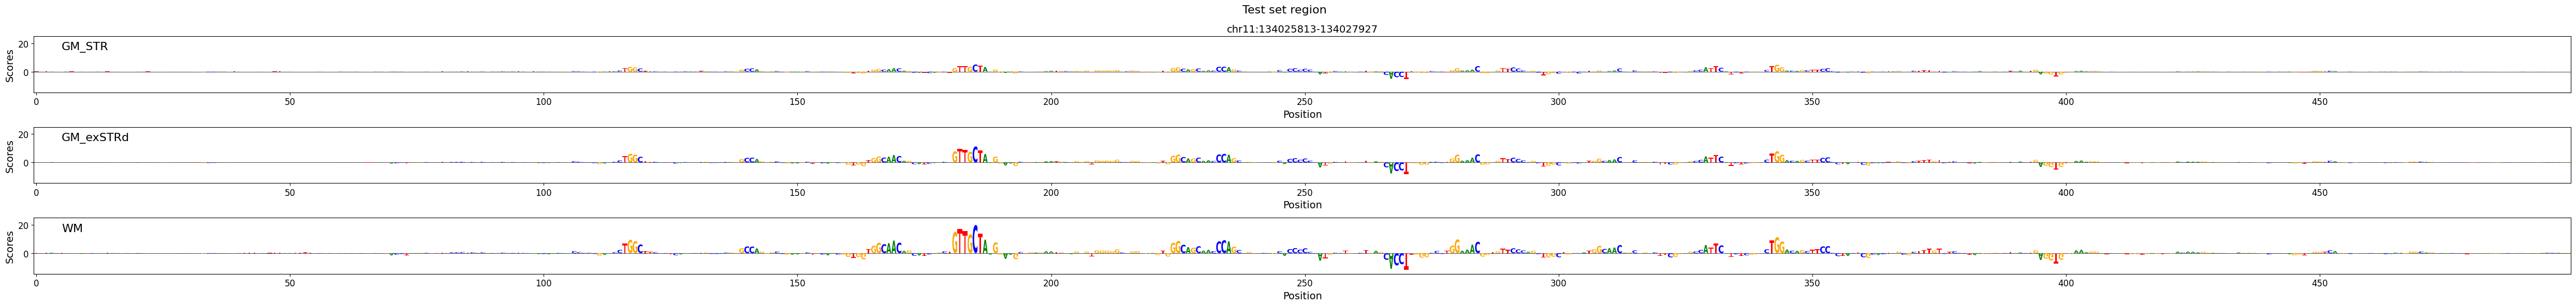

In [30]:
crested.pl.patterns.contribution_scores(
    scores_2,
    one_hot_encoded_sequences,
    sequence_labels=[region],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
)  # zoom in on the center 500bp

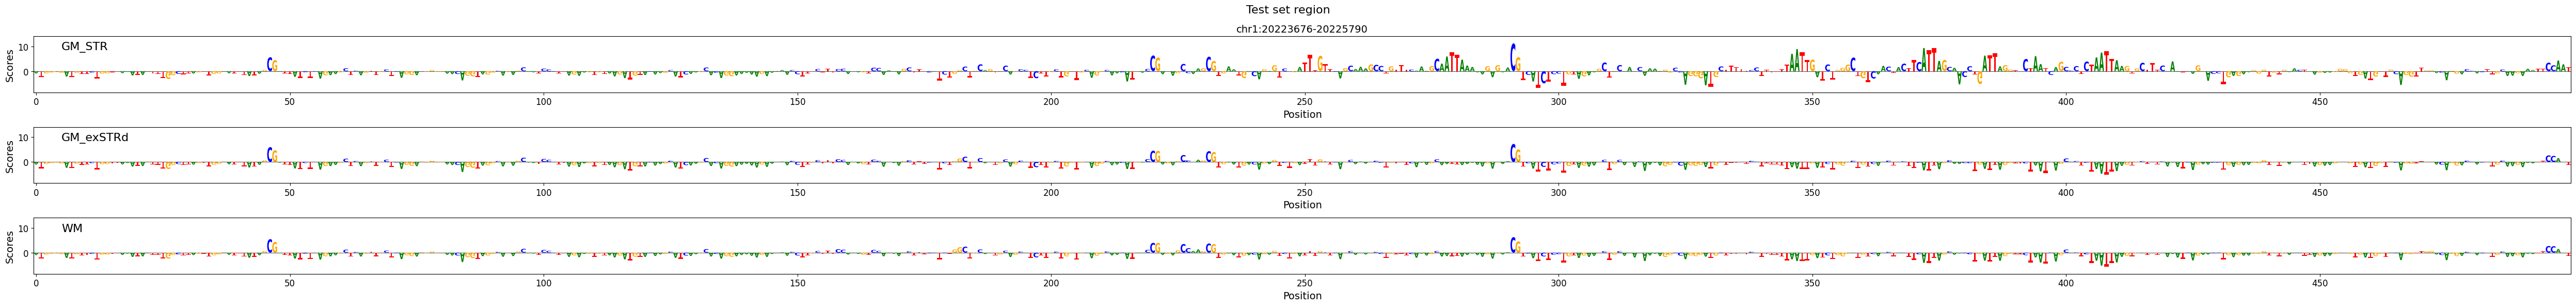

In [71]:
crested.pl.patterns.contribution_scores(
    scores_3,
    one_hot_encoded_sequences,
    sequence_labels=[region],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
)  # zoom in on the center 500bp

# Modisco

In [8]:
# load a trained model
import keras

model_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_human/full_universe_base_subset_filtered_ft_2_dars_ft///checkpoints/05.keras"
model = keras.models.load_model(model_path, compile=False)  # change to your model path

In [9]:
adata= ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_dars.h5ad")


In [10]:
# store predictions for all our regions in the anndata object for later inspection.
import pysam
from tqdm import tqdm
fasta = pysam.FastaFile(genome_fasta)

seqs = [
    fasta.fetch(chrom, start, end)
    for chrom, start, end in tqdm(zip(adata.var['chr'], adata.var['start'], adata.var['end']))
]


predictions = crested.tl.predict(seqs, model, verbose=2)
adata.layers["finetuned"] =predictions.T  # adata expects (C, N) instead of (N, C)

11998it [01:02, 191.07it/s]
I0000 00:00:1753307346.071695 3301049 service.cc:148] XLA service 0x7faaf400d000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753307346.071724 3301049 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-07-23 14:49:06.091682: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753307346.160134 3301049 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-07-23 14:49:09.451136: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,512,1,1055]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,512,1,1057]{3,2,1,0}, f32[512,512,1,3]{3,2,1,0}), window={size=1x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_s

94/94 - 41s - 439ms/step


In [11]:
adata_combined = adata.copy()  # Copy the peak heights
adata_combined.X = (
    adata_combined.X + adata_combined.layers["finetuned"]
) / 2  # Take the average with the predictions

In [12]:
# most informative regions per class
adata_filtered = adata_combined.copy()
top_k = 500  # Here we take the top 2k most specific regions, but doing this on top 500 or top 1k will give similar results and will be faster to calculate
crested.pp.sort_and_filter_regions_on_specificity(
    adata_filtered, top_k=top_k, method="proportion"
)
adata_filtered

2025-07-23T14:49:47.164110-0700 INFO After sorting and filtering, kept 1500 regions.


AnnData object with n_obs × n_vars = 3 × 1500
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split', 'Class name', 'rank', 'proportion_score'
    layers: 'finetuned'

In [10]:
adata_filtered.write_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/astro_dars_filtered.h5ad")

### !!!!!! We are combining the most specific regions per cell type so every class calculates contribution scores for all of them. This is to really go into specificity.

In [52]:
from anndata import AnnData
import numpy as np
import pandas as pd
import scipy.sparse as sp

region_df = adata_filtered.var.reset_index()  # get 'region' as column
target_classes = region_df['Class name'].unique()

# Repeat var with same region index
repeated_var = pd.concat([
    region_df.assign(**{'Class name': cls}) for cls in target_classes
], ignore_index=True)

# Restore the region index (duplicated now!)
repeated_var.index = repeated_var['region']  # this is allowed

# Repeat X
X = adata_filtered.X
if sp.issparse(X):
    X = X.toarray()
X_repeated = np.tile(X, (1, len(target_classes)))  # repeat along columns

# Create new AnnData
adata_repeated = AnnData(
    X=X_repeated,
    obs=adata_filtered.obs.copy(),
    var=repeated_var
)

/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [53]:

adata_repeated.var['Class name'].value_counts()
adata_repeated.var

,region,chr,start,end,split,Class name,rank,proportion_score
region,,,,,,,,
chr18:59386480-59388594,chr18:59386480-59388594,chr18,59386480,59388594,test,GM_STR,1,0.786272
chr16:21226935-21229049,chr16:21226935-21229049,chr16,21226935,21229049,train,GM_STR,2,0.774130
chr3:157030763-157032877,chr3:157030763-157032877,chr3,157030763,157032877,train,GM_STR,3,0.764006
chr13:100635548-100637662,chr13:100635548-100637662,chr13,100635548,100637662,train,GM_STR,4,0.749345
chr2:235903019-235905133,chr2:235903019-235905133,chr2,235903019,235905133,train,GM_STR,5,0.742144
...,...,...,...,...,...,...,...,...
chr15:98002013-98004127,chr15:98002013-98004127,chr15,98002013,98004127,train,WM,496,0.512836
chr10:98360745-98362859,chr10:98360745-98362859,chr10,98360745,98362859,val,WM,497,0.512793
chr15:52294772-52296886,chr15:52294772-52296886,chr15,52294772,52296886,train,WM,498,0.512783


chr                      chr7
start                45574580
end                  45576694
split                   train
Class name          GM_exSTRd
rank                        1
proportion_score     0.578582
Name: chr7:45574580-45576694, dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


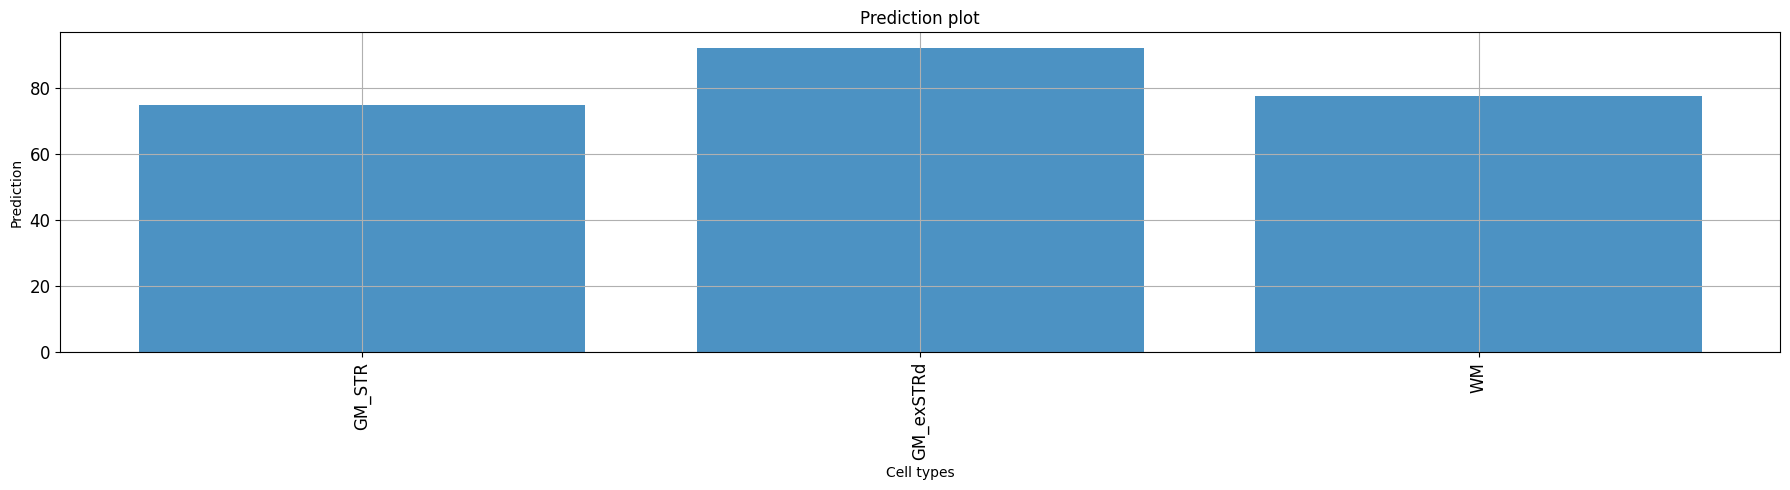

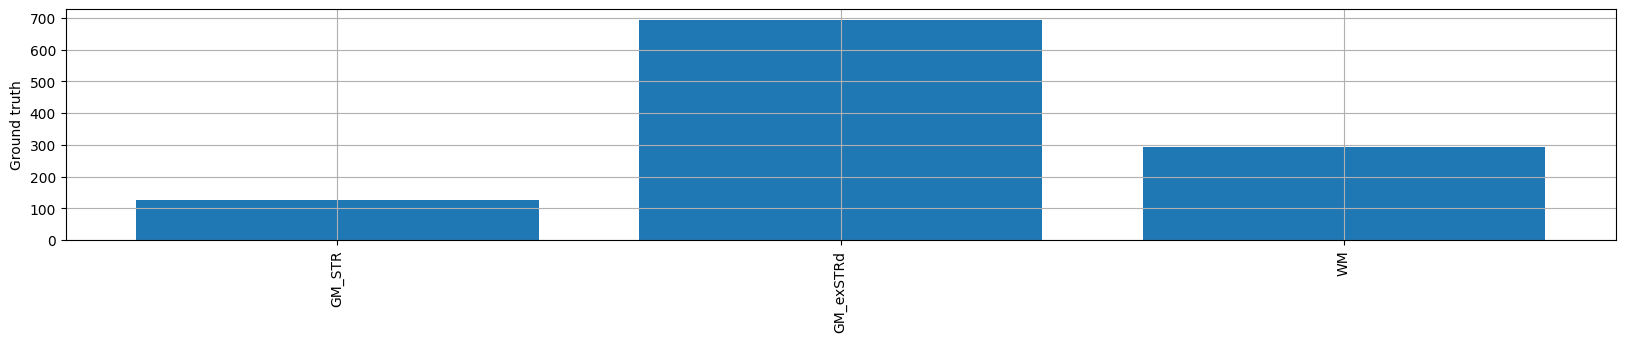

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
idx = 500
reg = adata_filtered.var.iloc[idx]
print(reg)
chrom = reg['chr']
start = reg['start']
end = start+2114
seq_id = chrom+':'+str(start)+'-'+str(end)
sequence = genome.fetch(chrom, start, end)
prediction = crested.tl.predict(sequence, model)
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names), x_label_rotation=90, height=5)
name = adata_filtered.var.index[idx]
reg_idx = adata.var_names.get_loc(name)
plt.figure(figsize=(20,3))
plt.bar(adata.obs_names, adata.X.T[reg_idx])
plt.xticks(rotation=90)
plt.ylabel('Ground truth')
plt.grid('on')

In [29]:
import numpy as np
cl_idx = int(np.argmax(prediction))
class_= np.array(list(adata.obs_names))
class_idx = list(adata.obs_names.get_indexer(class_))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,  # None (=all classes), list of target indices, or empty list (='combined' class)
    model=model,
    method="integrated_grad",  # default. Other options: "integrated_grad", "mutagenesis"
)

2025-07-23T14:58:58.321052-0700 INFO Calculating contribution scores for 3 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:08<00:00,  8.27s/it]


In [30]:
class_

array(['GM_STR', 'GM_exSTRd', 'WM'], dtype='<U9')

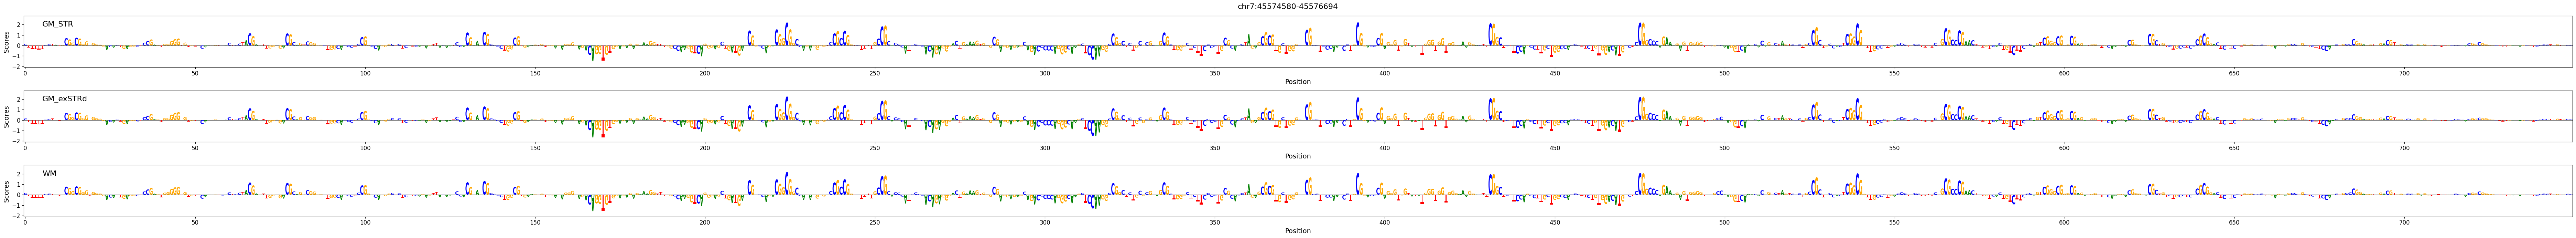

In [31]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[""],
    class_labels=list(class_),
    zoom_n_bases=750,
    title=seq_id,
    height=7
)  # zoom in on the center 500bp

### Calc contribs

In [54]:
class_regions = adata_repeated.var[adata_repeated.var["Class name"] == "GM_STR"].index.tolist()
len(class_regions)

1500

In [55]:
crested.tl.contribution_scores_specific(
    input=adata_repeated,
    target_idx=None,  # We calculate for all classes
    model=model,
    method='integrated_grad',
    output_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/combined_modisco_results_ft_500/",
    verbose=True
)

2025-07-23T15:16:27.891860-0700 INFO Calculating contribution scores for 1 class(es) and 1500 region(s).


Model: 100%|██████████| 1/1 [02:02<00:00, 122.95s/it]


2025-07-23T15:18:43.674741-0700 INFO Calculating contribution scores for 1 class(es) and 1500 region(s).


Model: 100%|██████████| 1/1 [02:00<00:00, 120.19s/it]


2025-07-23T15:20:56.687228-0700 INFO Calculating contribution scores for 1 class(es) and 1500 region(s).


Model: 100%|██████████| 1/1 [02:00<00:00, 120.77s/it]


(array([[[[-1.70618569e-05,  3.78212979e-04, -1.17278141e-04, ...,
            8.22013651e-04,  6.59506710e-04, -3.12791206e-04],
          [ 2.01671151e-04, -4.44032397e-04,  3.92703456e-04, ...,
           -1.47867016e-03, -2.53863516e-04,  2.80878361e-04],
          [ 7.03902770e-05,  3.97985510e-04,  2.94074998e-05, ...,
            5.85876522e-04, -5.41122106e-04,  1.94503751e-04],
          [-3.23636166e-04, -3.32576456e-04, -3.34725446e-05, ...,
            4.06186969e-04,  3.36883153e-04,  3.44978689e-05]]],
 
 
        [[[ 1.22830935e-03,  1.02857621e-02,  1.45319453e-03, ...,
            3.73843446e-04,  4.97291097e-04,  6.77276548e-05],
          [ 1.93735713e-03,  1.51650084e-03,  1.05801281e-02, ...,
            3.78820463e-04,  2.87409726e-04,  1.90818337e-05],
          [-3.29440669e-03, -1.11993998e-02, -1.50597598e-02, ...,
           -2.33932762e-04,  6.37680758e-04,  2.64055183e-04],
          [ 1.97756849e-03,  2.32170429e-03,  2.78088590e-03, ...,
            1.689

In [56]:
meme_db, motif_to_tf_file = crested.get_motif_db()

In [ ]:
import numpy as np

# Load the .npz files
seqs1 = np.load('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/combined_modisco_results_ft_500/GM_STR_oh.npz')
seqs2 = np.load('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/combined_modisco_results_ft_500/GM_exSTRd_oh.npz')
seqs2 = np.load('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/evogen-dnaseq-modeling/basal_ganglia/astro/combined_modisco_results_ft_500/WM_oh.npz')

# Check keys
print(data1.files)  # e.g., ['X'], or ['arr_0'], etc.

# Concatenate each array by key
combined = {}
for key in data1.files:
    combined[key] = np.concatenate([data1[key], data2[key], data3[key]], axis=0)

# Optionally save to a new file
np.savez('combined.npz', **combined)

In [57]:
import os
os.environ["PATH"] = "/home/niklas.kempynck/meme/bin:" + os.environ["PATH"]

In [ ]:
# run tfmodisco on the contribution scores
crested.tl.modisco.tfmodisco(
    window=1000,
    output_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/combined_modisco/",
    contrib_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/combined_modisco/",
    report=True,  # Optional, will match patterns to motif MEME database
    meme_db=meme_db,  # File to MEME database
    max_seqlets=20000,
)

2025-07-23T16:42:44.233865-0700 INFO No class names provided, using all found in the contribution directory: ['combined']
Modisco results already exist for class: combined
